In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load Data

In [2]:
# Load IRIS Data into a dataframe
from sklearn import datasets
iris = datasets.load_iris()    
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],columns= iris['feature_names'] + ['target'])

# Target and Data
y = df['target']
X = df[[col for col in df.columns if col not in ['target']]]

In [3]:
# Settings
n_components = None
data = X.copy()

# PCA and Features

In [4]:
# Conduct PCS
pca = PCA()
p_components = pca.fit_transform(data)
p_components = pd.DataFrame(p_components)

# Add the principal component columns
p_components.columns = p_components.columns+1
p_components = p_components.add_prefix('Principal Component ')
output_data = pd.concat([data,p_components], axis = 1)
print("Original Data With Principal Components Added")
display(output_data)

# Explained Variance (Eigenvalues)
eigenvalues = pca.explained_variance_

# Explained Variance Ratios
ev_ratios = pca.explained_variance_ratio_

# Eigenvalues Matrix
ev_matrix = pd.DataFrame({'eigenvalues':eigenvalues, 'ev_ratios':ev_ratios, 'cum_percent':ev_ratios.cumsum()*100})
print("Matrix of Eigenvalues for a Pareto Diagram")
display(ev_matrix)

# Covariance Matrix
covariance_matrix = pd.DataFrame(pca.get_covariance())
covariance_matrix.columns = data.columns
covariance_matrix.index = data.columns
print("Covariance Matrix")
display(covariance_matrix)

# Egenvectors
eigenvectors = pd.DataFrame(pca.components_)
eigenvectors.columns = p_components.columns
eigenvectors.index = data.columns
print("Eigenvectors")
display(eigenvectors) 

Original Data With Principal Components Added


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4
0,5.1,3.5,1.4,0.2,-2.684126,0.319397,-0.027915,-0.002262
1,4.9,3.0,1.4,0.2,-2.714142,-0.177001,-0.210464,-0.099027
2,4.7,3.2,1.3,0.2,-2.888991,-0.144949,0.017900,-0.019968
3,4.6,3.1,1.5,0.2,-2.745343,-0.318299,0.031559,0.075576
4,5.0,3.6,1.4,0.2,-2.728717,0.326755,0.090079,0.061259
...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,1.944110,0.187532,0.177825,-0.426196
146,6.3,2.5,5.0,1.9,1.527167,-0.375317,-0.121898,-0.254367
147,6.5,3.0,5.2,2.0,1.764346,0.078859,0.130482,-0.137001
148,6.2,3.4,5.4,2.3,1.900942,0.116628,0.723252,-0.044595


Matrix of Eigenvalues for a Pareto Diagram


,eigenvalues,ev_ratios,cum_percent
0,4.228242,0.924619,92.461872
1,0.242671,0.053066,97.768521
2,0.078210,0.017103,99.478782
3,0.023835,0.005212,100.000000


Covariance Matrix


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),0.685694,-0.042434,1.274315,0.516271
sepal width (cm),-0.042434,0.189979,-0.329656,-0.121639
petal length (cm),1.274315,-0.329656,3.116278,1.295609
petal width (cm),0.516271,-0.121639,1.295609,0.581006


Eigenvectors


,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4
sepal length (cm),0.361387,-0.084523,0.856671,0.358289
sepal width (cm),0.656589,0.730161,-0.173373,-0.075481
petal length (cm),-0.582030,0.597911,0.076236,0.545831
petal width (cm),-0.315487,0.319723,0.479839,-0.753657


# Score Plot

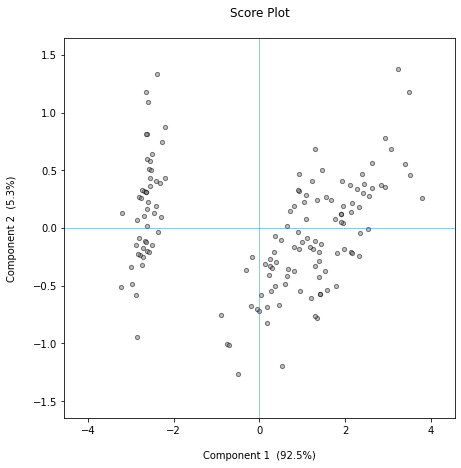

In [5]:
A = 1
B = 2

# Build plot
fig, ax = plt.subplots(figsize=(7,7))

x_val = output_data[f"Principal Component {A}"]
y_val = output_data[f"Principal Component {B}"]

# Some styles only make sense if the number of points to plot
# are below certain thresholds...
marker = "o" if len(output_data ) < 50 else "."
ax.scatter(x_val, y_val, marker=marker, s = 70, color="grey", ec="k", alpha=0.5, label = 'Data')

# X and Y axis
ax.axhline(y=0, linestyle = '-', color = 'dodgerblue', linewidth = 0.5)
ax.axvline(x=0, linestyle = '-', color = 'dodgerblue', linewidth = 0.5)

# Max/ Min
x_limit = max(abs(x_val.min()), abs(x_val.max()))*1.20
ax.set_xlim(-x_limit, x_limit)
y_limit = max(abs(y_val.min()), abs(y_val.max()))*1.20
ax.set_ylim(-y_limit, y_limit)

# Labels and Title
ax.set_ylabel(f"Component {B}  ({(round(ev_matrix.iloc[B-1]['ev_ratios'],3))*100}%)\n")
ax.set_xlabel(f"\nComponent {A}  ({(round(ev_matrix.iloc[A-1]['ev_ratios'],3))*100}%)")
ax.set_title('Score Plot\n')
plt.show()

# Loading Plot

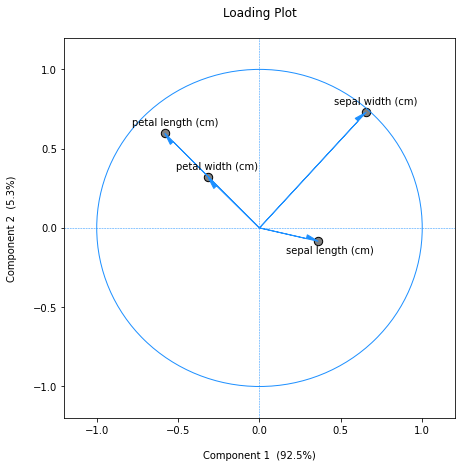

In [6]:
# Build plot
fig, ax = plt.subplots(figsize=(7,7))

eigen_x_val = eigenvectors[f"Principal Component {A}"]
eigen_y_val = eigenvectors[f"Principal Component {B}"]

# Add circle
circ = plt.Circle((0, 0), 1, color='dodgerblue', fill=False)
ax.add_patch(circ)

# X and Y axis
ax.axhline(y=0, linestyle = '--', color = 'dodgerblue', linewidth = 0.5)
ax.axvline(x=0, linestyle = '--', color = 'dodgerblue', linewidth = 0.5)

# Draw arrows and annotate
for i, row in eigenvectors.iterrows():
    
    # plot arrow
    ax.arrow(
        0, 0, 
        row[f"Principal Component {A}"], row[f"Principal Component {B}"], 
        color = 'dodgerblue', 
        length_includes_head = True,
        head_width = 0.05,
        shape = 'right',
        linewidth = 1, 
    )
    
    if row[f"Principal Component {B}"]<=0: vert_adj = -0.075
    else: vert_adj = 0.05
        
    ax.text(
        row[f"Principal Component {A}"]-0.2, row[f"Principal Component {B}"]+vert_adj,
        i
    )
# Scatterplot    
ax.scatter(eigen_x_val, eigen_y_val, marker="o", s = 70, color="grey", ec="k", alpha=1, label = 'Data')

# Max/ Min
ax.set_xlim(-1.20, 1.20)
ax.set_ylim(-1.20, 1.20)

# Labels and Title
ax.set_ylabel(f"Component {B}  ({(round(ev_matrix.iloc[B-1]['ev_ratios'],3))*100}%)\n")
ax.set_xlabel(f"\nComponent {A}  ({(round(ev_matrix.iloc[A-1]['ev_ratios'],3))*100}%)")
ax.set_title('Loading Plot\n')
plt.show()

In [7]:
ev_matrix

,eigenvalues,ev_ratios,cum_percent
0,4.228242,0.924619,92.461872
1,0.242671,0.053066,97.768521
2,0.078210,0.017103,99.478782
3,0.023835,0.005212,100.000000


# Eigenvalue Pareto Plot

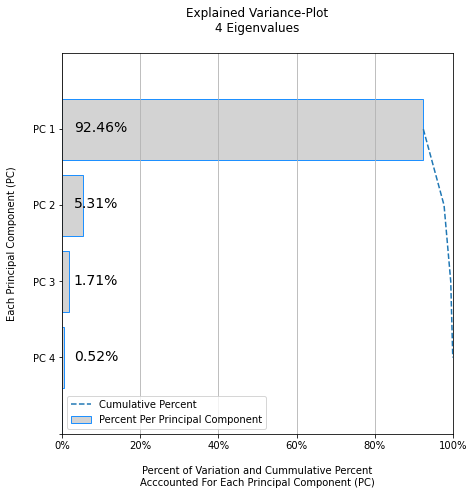

In [30]:
max_eigenvals = 10

# Set the max number of eigenvalues to show on the Pareto plot
num_eigenvals_to_show = len(ev_matrix)
max_threshold = False

if num_eigenvals_to_show > max_eigenvals:
    max_threshold = True
    num_eigenvals_to_show = max_eigenvals-1

# Build plot
fig, ax = plt.subplots(figsize=(7,7))

# Get the most recent values for a bar plot up to the max eigenvalues
eigenvalues = ev_matrix['eigenvalues'][0:(num_eigenvals_to_show + 1)].sort_values(ascending=False)  # only take the first 10 eigenvalues
ev_ratios = ev_matrix['ev_ratios'][0:(num_eigenvals_to_show + 1)].sort_values(ascending=False)*100
cum_percent = ev_matrix['cum_percent'][0:(num_eigenvals_to_show + 1)].sort_values(ascending=True)

# Append missing values if there are less than '(num_eigenvals_to_show + 1)'
if (num_eigenvals_to_show + 1)-len(eigenvalues) > 0:
    
    blank_vals = list(np.full((1,(num_eigenvals_to_show + 1)-len(eigenvalues)), fill_value = '')[0])
    y_labels = round(ev_ratios,2).append(pd.Series(blank_vals))
    y_labels =[f'{val}%' if '' != val else '' for val in y_labels]

    zero_vals = list(np.full((1,(num_eigenvals_to_show + 1)-len(eigenvalues)), fill_value = 0)[0])
    y_nums = ev_ratios.append(pd.Series(zero_vals))

y_vals = np.arange((num_eigenvals_to_show + 1)-1,-1,-1)

# Make the bar plot, cumulative percentage plots, etc. 
ax.barh(y_vals, y_nums[0:len(y_vals)], align='center', color = 'lightgrey', edgecolor = 'dodgerblue', alpha=1, label = 'Percent Per Principal Component')
ax.plot(cum_percent, y_vals[:len(cum_percent)], linestyle = '--', label = 'Cumulative Percent')

# X Axis Ticker Format
fmt = '{x:,.0f}%'
tick = mpl.ticker.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)

# X limit
ax.set_xlim(0,100)

# Title changes to alert user of missing eigenvalues if the max threshold is less than the number eigenvalues available. 
if max_threshold:  # missing eigenvalues because there are more than the max threshold
    not_shown = len(ev_matrix)-max_eigenvals
    ax.set_title(f'Explained Variance-Pareto Plot\n{num_eigenvals_to_show+1} Eigenvalues\n{not_shown} Eigenvalue(s) not displayed.\n')
    ax.set_ylim(-1,(num_eigenvals_to_show + 1))
    
else:
    ax.set_title(f'Explained Variance-Plot\n{num_eigenvals_to_show} Eigenvalues\n') 
    ax.set_ylim(0,(num_eigenvals_to_show + 1))

ax.set_xlabel('\nPercent of Variation and Cummulative Percent\nAcccounted For Each Principal Component (PC)')

# Set Y values and tick lables
ax.set_ylabel(f'Each Principal Component (PC)\n')
ax.set_yticks(y_vals)

# Make sure to label the principal components corresponding to the Eigenvalues
new_y_labels = []
for count in range(1, len(y_labels)+1):
    new_val = f'PC {count}'
    
    if count == len(y_labels):
        new_y_labels.append('')
    else:
        new_y_labels.append(new_val)
    ax.text(3,count-0.04, y_labels[len(y_labels)-count-1], fontsize = 14)
    
ax.set_yticklabels(new_y_labels[0:len(y_vals)])
ax.grid(axis="x")
ax.legend(loc = 3)
plt.show()

# Scree Plot

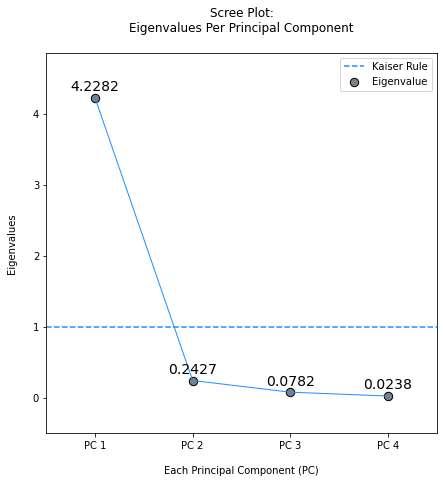

In [17]:
max_eigenvals = 10

# Build plot
fig, ax = plt.subplots(figsize=(7,7))

# Some styles only make sense if the number of points to plot
# are below certain thresholds...
marker = "o" if len(eigenvalues) < 50 else "."
ax.scatter(
    np.arange(0,(len(eigenvalues)))[0:max_eigenvals], 
    eigenvalues[0:max_eigenvals],
    marker=marker, 
    s = 70, 
    color="grey", ec="k", alpha=1, 
    label = 'Eigenvalue'
)
ax.plot(eigenvalues[0:max_eigenvals], color = 'dodgerblue', linewidth = 1)

# Plot Eigenvalues

for i in range(0,len(eigenvalues)):
    val = round(eigenvalues[i],4)
    text_loc_y = val+0.1
    text_loc_x = i-0.25
    ax.text(text_loc_x, text_loc_y, val, fontsize = 14)

ax.axhline(y=1, color = 'dodgerblue', linestyle = '--', label='Kaiser Rule')
ax.set_ylim(-0.5, np.max(eigenvalues)*1.15)
ax.set_xlim(-0.5, len(eigenvalues)-0.5)

ax.set_title('Scree Plot:\nEigenvalues Per Principal Component\n')
ax.set_ylabel('Eigenvalues\n')
ax.set_xlabel('\nEach Principal Component (PC)')

ax.set_xticks(np.arange(0, len(eigenvalues))[0:max_eigenvals])
ax.set_xticklabels([f'PC {val}' for val in np.arange(1,len(eigenvalues)+1)][0:max_eigenvals])
ax.legend()

